In [8]:
from autolens.profiles import mass_profiles as mp
from autolens.profiles import light_profiles as lp
from autolens.lensing import galaxy as g
from autolens.lensing import ray_tracing
from autolens.imaging import mask
from autolens.plotting import plane_plotters
from autolens.plotting import galaxy_plotters
from autolens.plotting import ray_tracing_plotters

from astropy import cosmology

# In this example, we'll reinforce what we learnt about ray-tracing in the last tutorial and introduce the following
# new concepts:

# 1) Short-hand notation for setting up profiles and galaxies, to make code cleaner and easier to read.
# 2) That a tracer can be given any number of galaxies.
# 3) That by specifying redshifts and a cosmology, our results are converted to physical units of kiloparsecs (kpc).

In [9]:
# To begin, lets setup the grids we 'll ray-trace using. Lets do something crazy, and use a 
# higher resolution grid then before and set the sub grid size to 4x4 per pixel!
image_plane_grids = mask.ImagingGrids.from_shape_and_pixel_scale(shape=(200, 200), pixel_scale=0.025, sub_grid_size=4)
print(image_plane_grids.image.shape)
print(image_plane_grids.sub.shape) # Every image-pixel is sub-gridded by 4x4, so the sub-grid has x16 more coordinates.

(40000, 2)
(640000, 2)


In [10]:
# Next, lets setup a lens galaxy. In the previous tutorial, we set up each profile one line at a time. This made
# code long and cumbersome to read. This time we'll setup easy galaxy using one block of code. 
 
# To help us, we've imported the 'light_profiles' and 'mass_profiles' modules as 'lp' and 'mp', and the 
# 'galaxy' module as 'g'.

# We'll also give the lens galaxy some attributes we didn't in the last tutorial:

# 1) A light-profile, meaning its light will appear in the image-plane image.
# 2) An external shear, which accounts for the deflection of light due to line-of-sight structures.
# 3) A redshift, which the tracer will use to convert arc second coordinates to kpc.
lens_galaxy = g.Galaxy(light=lp.SphericalSersic(centre=(0.0, 0.0), intensity=2.0, effective_radius=0.5, 
                                                sersic_index=2.5),
                       mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=90.0, einstein_radius=1.6),
                       shear=mp.ExternalShear(magnitude=0.05, phi=45.0),
                       redshift=0.5)
print(lens_galaxy)

Redshift: 0.5
Light Profiles:
SphericalSersic
centre: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 2.0
effective_radius: 0.5
sersic_index: 2.5
Mass Profiles:
EllipticalIsothermal
centre: (0.0, 0.0)
axis_ratio: 0.8
phi: 90.0
einstein_radius: 1.6
slope: 2.0
core_radius: 0.0
ExternalShear
centre: (0.0, 0.0)
axis_ratio: 1.0
phi: 45.0
magnitude: 0.05


In [12]:
# Lets also create a small satellite galaxy nearby the lens galaxy and at the same redshift.
lens_satellite = g.Galaxy(light=lp.SphericalDevVaucouleurs(centre=(1.0, 0.0), intensity=2.0, effective_radius=0.2),
                          mass=mp.SphericalIsothermal(centre=(1.0, 0.0), einstein_radius=0.4),
                          redshift=0.5)
print(lens_satellite)


Redshift: 0.5
Light Profiles:
SphericalDevVaucouleurs
centre: (1.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 2.0
effective_radius: 0.2
sersic_index: 4.0
Mass Profiles:
SphericalIsothermal
centre: (1.0, 0.0)
axis_ratio: 1.0
phi: 0.0
einstein_radius: 0.4
slope: 2.0
core_radius: 0.0


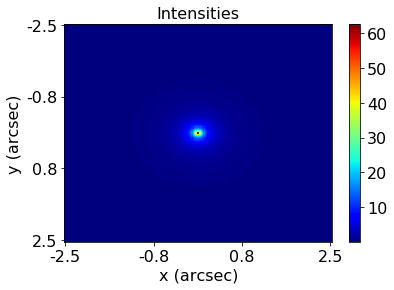

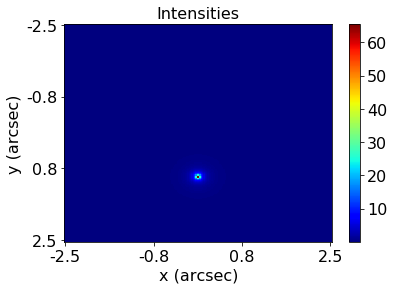

In [13]:
# Lets have a quick look at the appearance of our lens galaxy and its satellite
galaxy_plotters.plot_intensities(galaxy=lens_galaxy, grid=image_plane_grids.image)
galaxy_plotters.plot_intensities(galaxy=lens_satellite, grid=image_plane_grids.image)

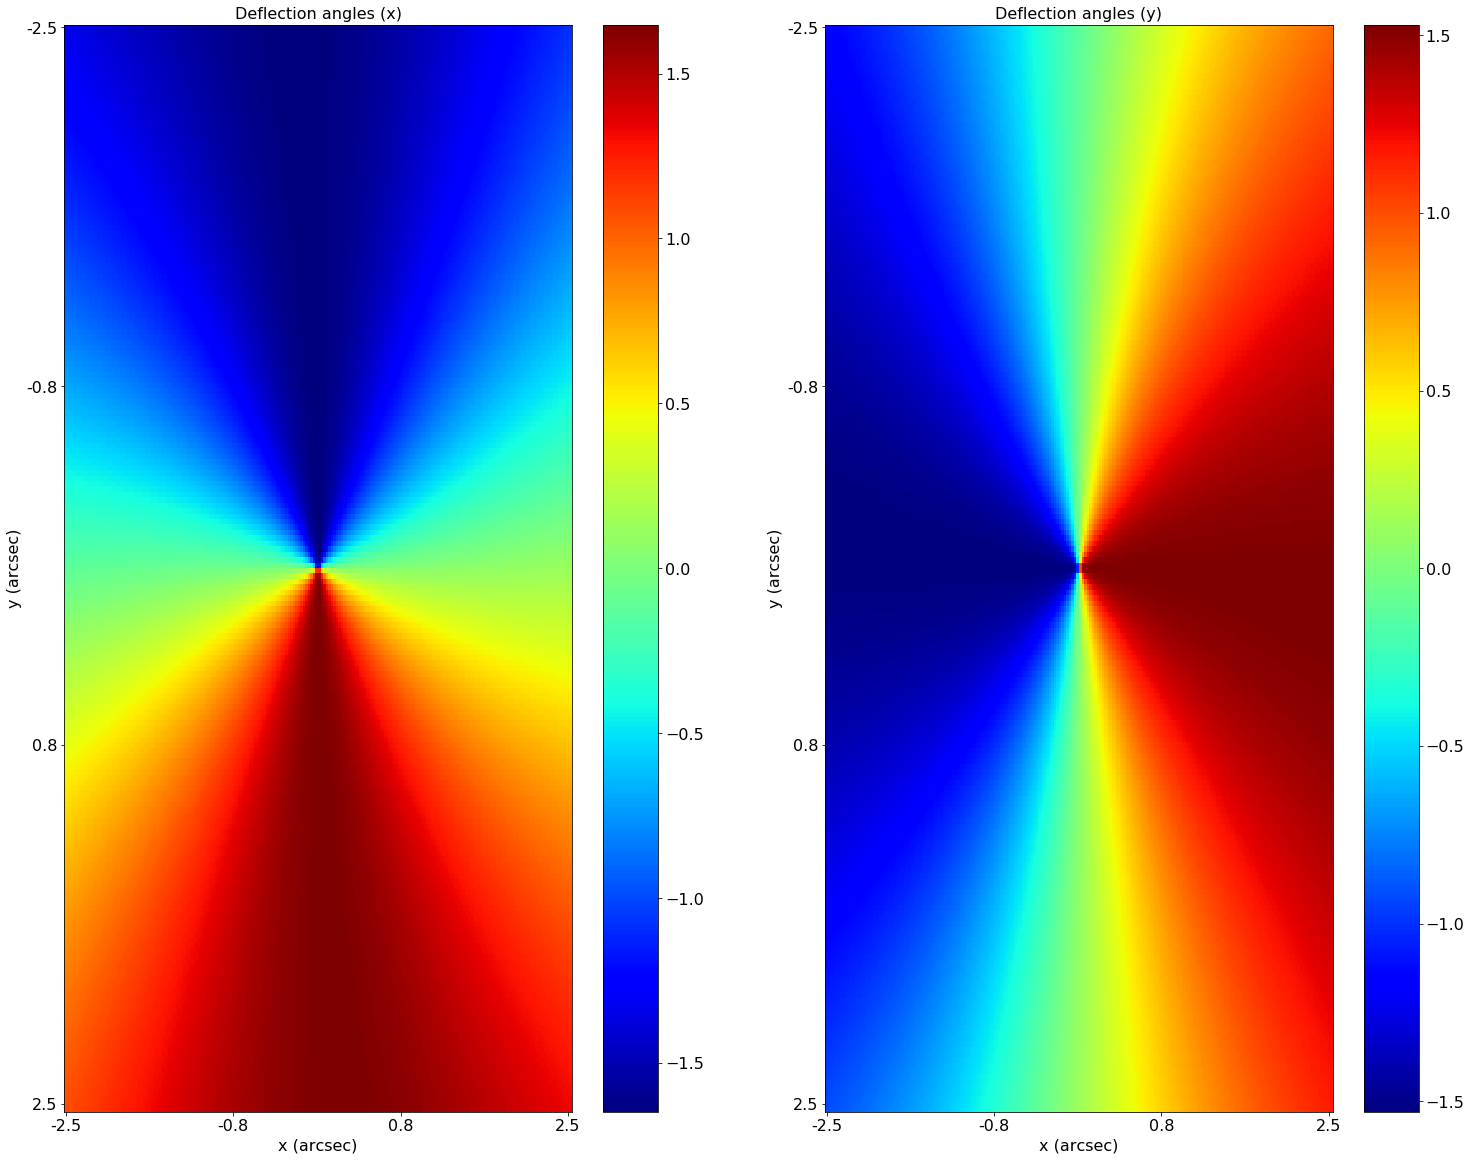

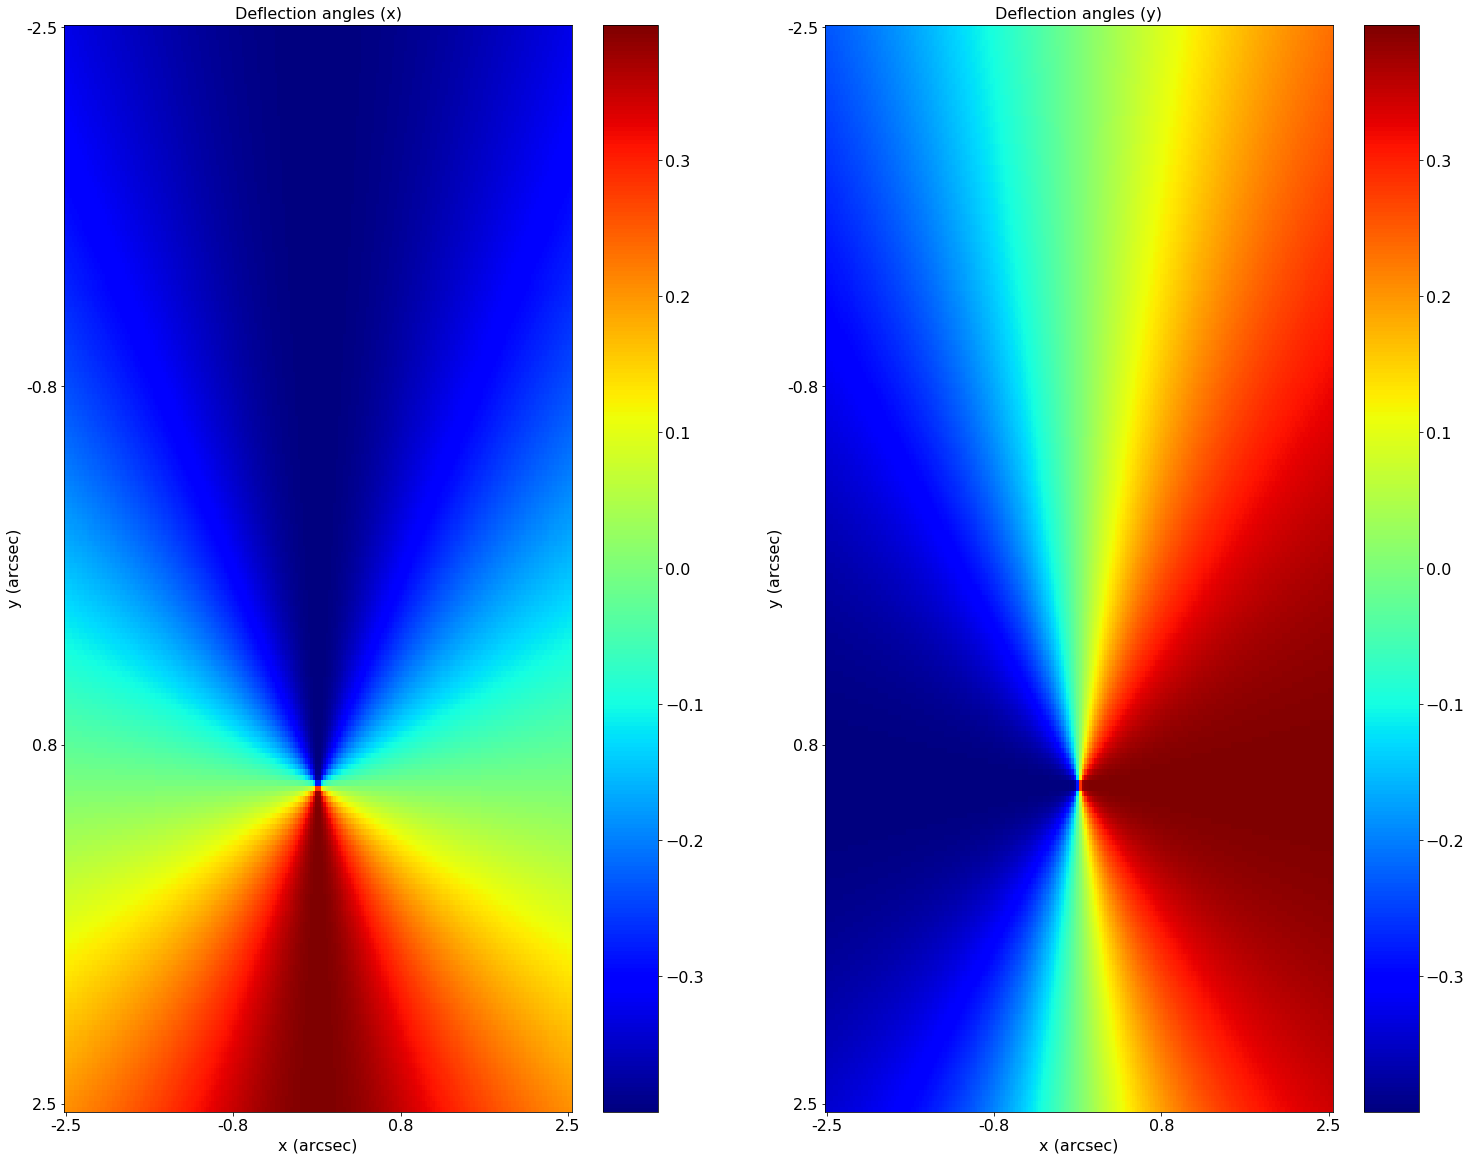

In [14]:
# And their deflection angles - note that the satellite doesn't contribute as much to light's deflection
galaxy_plotters.plot_deflections(galaxy=lens_galaxy, grid=image_plane_grids.image)
galaxy_plotters.plot_deflections(galaxy=lens_satellite, grid=image_plane_grids.image)

In [15]:
# Now, lets make two source galaxies. Lets not use the terms 'light' and 'mass' to setup the light and mass profiles. 
# Instead, lets use more descriptive names of what we think each component represents ( e.g. a 'bulge' and 'disk').
source_galaxy_0 = g.Galaxy(bulge=lp.SphericalDevVaucouleurs(centre=(0.1, 0.2), intensity=0.3, effective_radius=0.3),
                           disk=lp.EllipticalExponential(centre=(0.1, 0.2), axis_ratio=0.8, phi=45.0, intensity=3.0,
                                                       effective_radius=2.0),
                           redshift=1.0)

source_galaxy_1 = g.Galaxy(disk=lp.EllipticalExponential(centre=(-0.3, -0.5), axis_ratio=0.6, phi=80.0, intensity=8.0,
                                                         effective_radius=1.0),
                           redshift=1.0)
print(source_galaxy_0)
print(source_galaxy_1)

Redshift: 1.0
Light Profiles:
SphericalDevVaucouleurs
centre: (0.1, 0.2)
axis_ratio: 1.0
phi: 0.0
intensity: 0.3
effective_radius: 0.3
sersic_index: 4.0
EllipticalExponential
centre: (0.1, 0.2)
axis_ratio: 0.8
phi: 45.0
intensity: 3.0
effective_radius: 2.0
sersic_index: 1.0
Redshift: 1.0
Light Profiles:
EllipticalExponential
centre: (-0.3, -0.5)
axis_ratio: 0.6
phi: 80.0
intensity: 8.0
effective_radius: 1.0
sersic_index: 1.0


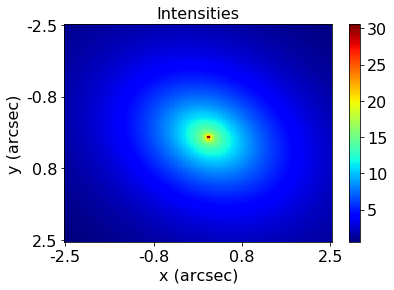

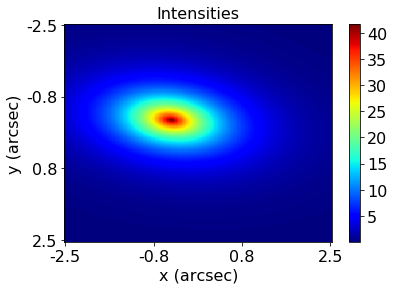

In [17]:
# Lets look at our source galaxies (before lensing)
galaxy_plotters.plot_intensities(galaxy=source_galaxy_0, grid=image_plane_grids.image)
galaxy_plotters.plot_intensities(galaxy=source_galaxy_1, grid=image_plane_grids.image)

In [ ]:
# Lets see what the individual light profile components (in this example, the bulge and disk)
galaxy_plotters.plot_intensities_individual(galaxy=source_galaxy_0, grid=image_plane_grids.image)
galaxy_plotters.plot_intensities_individual(galaxy=source_galaxy_1, grid=image_plane_grids.image)

In [15]:
# Now lets pass these our 4 galaxies to ray_tracing, which means the following will occur:

# 1) Using every mass-profile in each lens galaxy, the deflection angles are computed.
# 2) These deflection angles are summed, such that the deflection of light due to every mass-profile and both
# the lens galaxy and its satellite is computed. 
# 3) These deflection angles are used to trace every image-grid and sub-grid coordinate to a source-plane coordinate.
# 4) The light of all source galaxies is ray-traced back forward to form our image-plane image.

# Note that we've also supplied the tracer below with a Planck15 cosmology.
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy, lens_satellite],
                                             source_galaxies=[source_galaxy_0, source_galaxy_1],
                                             image_plane_grids=image_plane_grids, cosmology=cosmology.Planck15)

[[-2.4875 -2.4875]
 [-2.4875 -2.4625]
 [-2.4875 -2.4375]
 ...
 [ 2.4875  2.4375]
 [ 2.4875  2.4625]
 [ 2.4875  2.4875]]
[[-0.83291325 -1.09227512]
 [-0.827468   -1.07445017]
 [-0.82200144 -1.05672008]
 ...
 [ 0.94149225  0.94442584]
 [ 0.94740296  0.96278719]
 [ 0.95327361  0.98124829]]


/home/jammy/PyCharm/Projects/AutoLens/autolens/profiles/mass_profiles.py:436: RuntimeWarning: invalid value encountered in true_divide
  deflection_x = np.arctan(np.divide(np.multiply(np.sqrt(1 - self.axis_ratio ** 2), grid[:, 0]), psi))
/home/jammy/PyCharm/Projects/AutoLens/autolens/profiles/mass_profiles.py:437: RuntimeWarning: invalid value encountered in true_divide
  deflection_y = np.arctanh(np.divide(np.multiply(np.sqrt(1 - self.axis_ratio ** 2), grid[:, 1]), psi))


In [18]:
# As we did previous, we can inspect each grid.
plane_plotters.plot_plane_grid(plane=tracer.image_plane)
plane_plotters.plot_plane_grid(plane=tracer.source_plane)
# We can zoom in on the 'centre' of the source-plane (thistime, the lens galaxy was centred at (0.0, 0.0)
plane_plotters.plot_plane_grid(plane=tracer.source_plane, xmin=-0.2, xmax=0.2, ymin=-0.2, ymax=0.2)

NameError: name 'plane_plotters' is not defined

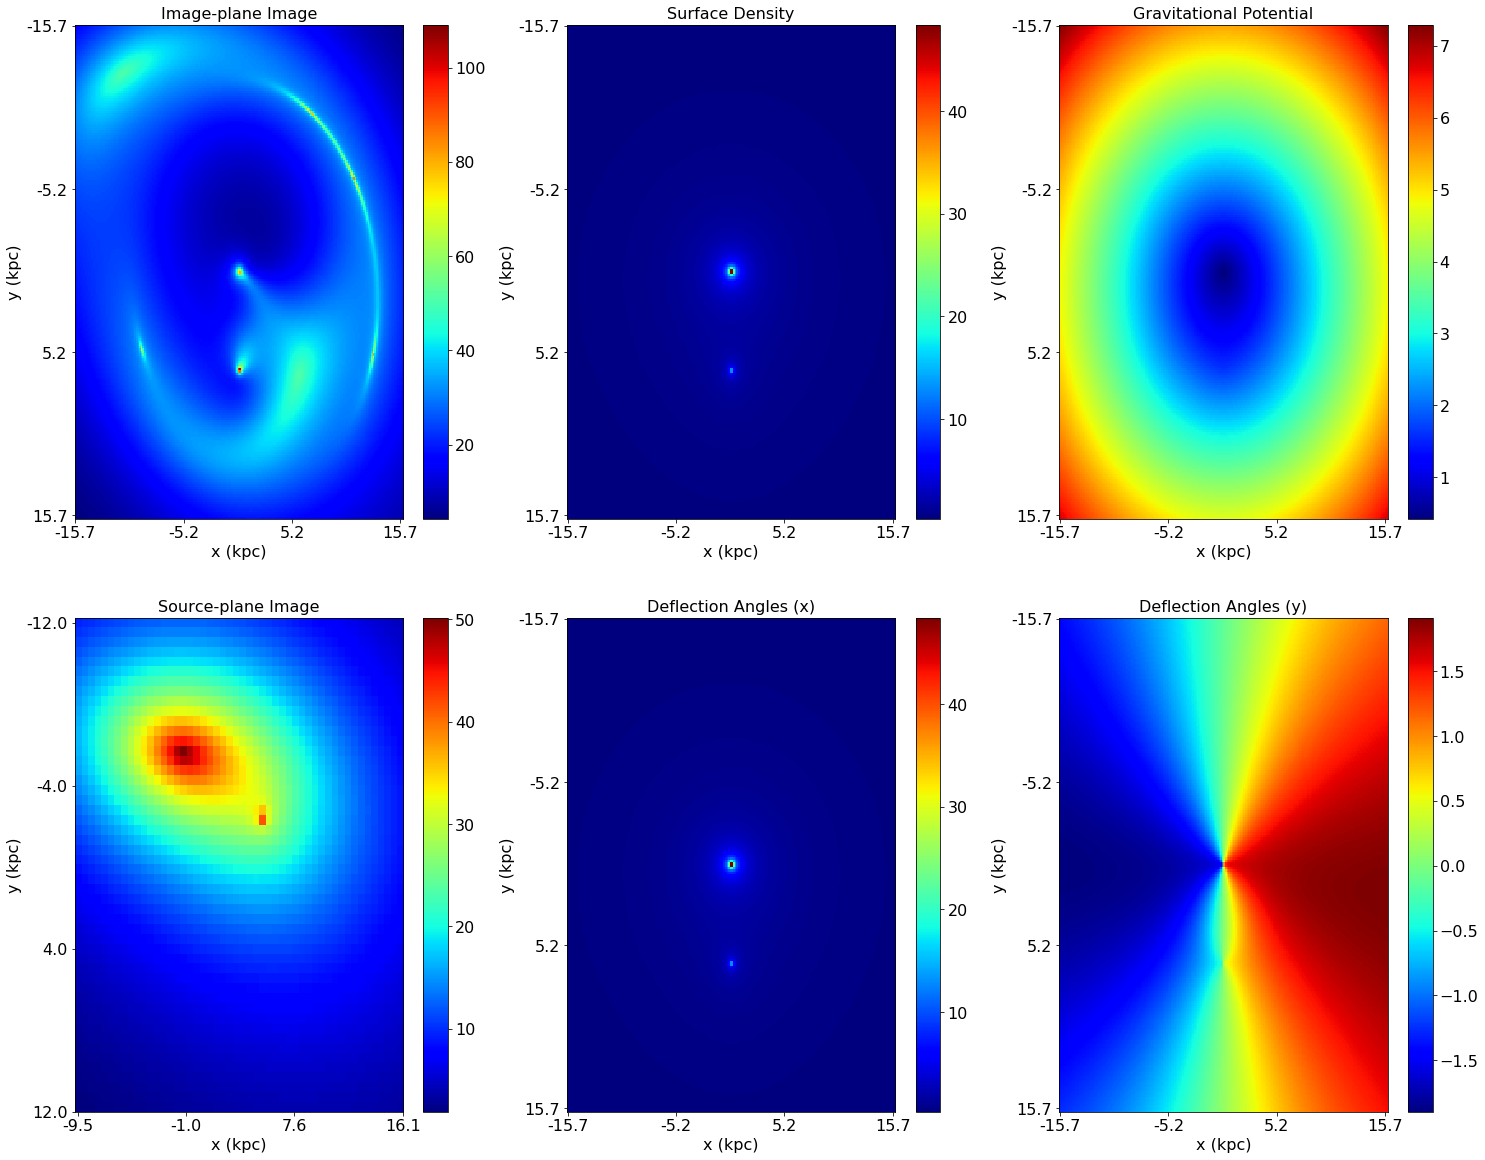

In [9]:
# Lets plot the lensing quantities again. Note that, because we supplied our galaxies with redshifts and our tracer 
# with a cosmology, our units have been conerted to kiloparsecs!
ray_tracing_plotters.plot_ray_tracing(tracer=tracer)

In [18]:
# In the previous example, we saw that the tracer had attributes we plotted (e.g. surface density, potential, etc.)
# Now we've input a cosmology and galaxy redshifts, the tracer has attributes associated with its cosmology.
print('Image-plane arcsec-per-kpc:')
print(tracer.image_plane.arcsec_per_kpc_proper)
print('Image-plane kpc-per-arcsec:')
print(tracer.image_plane.kpc_per_arcsec_proper)
print('Angular Diameter Distance to Image-plane:')
print(tracer.image_plane.angular_diameter_distance_to_earth)

print('Source-plane arcsec-per-kpc:')
print(tracer.source_plane.arcsec_per_kpc_proper)
print('Source-plane kpc-per-arcsec:')
print(tracer.source_plane.kpc_per_arcsec_proper)
print('Angular Diameter Distance to Source-plane:')
print(tracer.source_plane.angular_diameter_distance_to_earth)

print('Angular Diameter Distance From Image To Source Plane:')
print(tracer.angular_diameter_distance_from_image_to_source_plane)
print('Lensing Critical Surface Density:')
print(tracer.critical_density_kpc)

Image-plane arcsec-per-kpc:
0.15902722256138194
Image-plane kpc-per-arcsec:
6.288231561197116
Angular Diameter Distance to Image-plane:
1297040.8646071993
Source-plane arcsec-per-kpc:
0.12147853425766525
Source-plane kpc-per-arcsec:
8.231907028767104
Angular Diameter Distance to Source-plane:
1697952.7083327575
Angular Diameter Distance From Image To Source Plane:
725172.0598773579
Lensing Critical Surface Density:
3001935253.5346775


In [ ]:
# You might be wondering what the difference is between passing multiple galaxies to a tracer or
# using one galaxy with the same set of profiles. This will be explained in a few tutorials
# time.

# And with that, we've completed tutorial 5. Before moving on, try the following:

# 1) Decrease the einstein radius of the lens galaxy's satellite - what happens to the arc?
# 2) Add more light profiles to the lens-galaxy, can you see them in the image-plane image?
# 3) Add more source galaxies to the tracer - can you separate their different arcs?